# Start

In [19]:
import torch
import numpy as np
import fadtk
from fadtk.model_loader import CLAPLaionModel, CLAPLaionModel
from fadtk import Path
import torch
from tqdm import tqdm
import numpy as np
import logging
from evals.fadtk_utils import cache_embedding_files, split_to_overlapping_windows

from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    # "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 20
})


# Calc

In [6]:
ours_dir = "code/results/MusicDeltaDB_unsup/audioldm2-music"
split_ours_dir = "evals/ours"
sdedit_dir = "code/results/MusicDeltaDB_unsup_sdedit/audioldm2-music"
split_sdedit_dir = "evals/sdedit"
inputs_orig = "inputs/MusicDelta/"
split_inputs_orig = "evals/inputs"

# split all generations matching a pattern to almost-non-overlapping 10 second long segments
ours_ptrns = [
    '**/pcs*150--1*spts115*avgeval_a*2.0.wav',
    '**/pcs*150--1*spts95*avgeval_a*2.0.wav',
    '**/pcs*150--1*spts80*avgeval_a*2.0.wav',
    '**/pcs*150--1*spts65*avgeval_a*2.0.wav',
    '**/pcs*200--1*spts115*avgeval_a*2.0.wav',
    '**/pcs*200--1*spts95*avgeval_a*2.0.wav',
    '**/pcs*200--1*spts80*avgeval_a*2.0.wav',
    '**/pcs*200--1*spts65*avgeval_a*2.0.wav',
]
sdedits_ptrns = [
    '**/s*170*cfg3.0.wav',
    '**/s*160*cfg3.0.wav',
    '**/s*150*cfg3.0.wav',
    '**/s*130*cfg3.0.wav',
    '**/s*115*cfg3.0.wav', 
    '**/s*100*cfg3.0.wav',
    '**/s*85*cfg3.0.wav',
]
orig_ptrns = ['*.wav']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CLAPLaionModel('music')
workers = 1


## Split WAV files to overlapping windows

In [ ]:
split_to_overlapping_windows(ours_ptrns, ours_dir, split_ours_dir)
split_to_overlapping_windows(sdedits_ptrns, sdedit_dir, split_sdedit_dir)
split_to_overlapping_windows(orig_ptrns, inputs_orig, split_inputs_orig, save_dir_structure=False)

## Calc Embedding files

In [ ]:
# 1. Calculate embedding files for each dataset
for eval_dir, pattern in [
    (split_ours_dir, '**/pc*.wav'), 
    (split_sdedit_dir, '**/s*cfg3.0*.wav'), 
    (split_inputs_orig, '*.wav')]:
    print(eval_dir)
    cache_embedding_files(eval_dir, model, workers=workers, pattern=pattern)
# 2. Calculate FAD
logging.disable(logging.CRITICAL)

## Calc FADs to MusicDelta

In [ ]:
out_long = []

np.random.seed(0)
torch.manual_seed(0)

fad = fadtk.FrechetAudioDistance(model, audio_load_worker=workers, load_model=False)
for ptrn in tqdm(ours_ptrns, desc='ours'):
    if list(Path(split_ours_dir).glob(ptrn)) == []:
        continue
    ours_score_ninf = fad.score(split_inputs_orig, list(Path(split_ours_dir).glob(ptrn)))
    out_long.append({'type': 'ours', 'ptrn': ptrn, 'ours_score_ninf': ours_score_ninf})

for ptrn in tqdm(sdedits_ptrns, desc='sdedit'):
    if list(Path(split_sdedit_dir).glob(ptrn)) == []:
        continue
    sdedit_score_ninf = fad.score(split_inputs_orig, list(Path(split_sdedit_dir).glob(ptrn)))
    out_long.append({'type': 'sdedit', 'ptrn': ptrn, 'sdedit_score_ninf': sdedit_score_ninf})
torch.save(out_long, 'evals/out_long.pt')

## Calc FADs to FMA-pop

In [ ]:
out_long = []

np.random.seed(0)
torch.manual_seed(0)

fad = fadtk.FrechetAudioDistance(model, audio_load_worker=workers, load_model=False)
for ptrn in tqdm(ours_ptrns, desc='ours'):
    ptrn = ptrn[:-4] + '*' + ptrn[-4:]
    if list(Path(split_ours_dir).glob(ptrn)) == []:
        continue
    ours_score_ninf = fad.score('fma_pop', list(Path(split_ours_dir).glob(ptrn)))
    out_long.append({'type': 'ours', 'ptrn': ptrn, 'ours_score_ninf': ours_score_ninf})

for ptrn in tqdm(sdedits_ptrns, desc='sdedit'):
    ptrn = ptrn[:-4] + '*' + ptrn[-4:]
    if list(Path(split_sdedit_dir).glob(ptrn)) == []:
        continue
    sdedit_score_ninf = fad.score('fma_pop', list(Path(split_sdedit_dir).glob(ptrn)))
    out_long.append({'type': 'sdedit', 'ptrn': ptrn, 'sdedit_score_ninf': sdedit_score_ninf})
torch.save(out_long, 'evals/out_long_fmapop.pt')

In [17]:
fad_orig = []
fad_fmapop = []

np.random.seed(0)
torch.manual_seed(0)

fad = fadtk.FrechetAudioDistance(model, audio_load_worker=workers, load_model=False)
for ptrn in tqdm(ours_ptrns, desc='ours'):
    ptrn = ptrn[:-4] + '*' + ptrn[-4:]
    if list(Path(split_ours_dir).glob(ptrn)) == []:
        continue
    ours_score_ninf = fad.score(split_inputs_orig, list(Path(split_ours_dir).glob(ptrn)))
    fad_orig.append({'type': 'ours', 'ptrn': ptrn, 'ours_score_ninf': ours_score_ninf})
    ours_score_ninf = fad.score('fma_pop', list(Path(split_ours_dir).glob(ptrn)))
    fad_fmapop.append({'type': 'ours', 'ptrn': ptrn, 'ours_score_ninf': ours_score_ninf})

for ptrn in tqdm(sdedits_ptrns, desc='sdedit'):
    ptrn = ptrn[:-4] + '*' + ptrn[-4:]
    if list(Path(split_sdedit_dir).glob(ptrn)) == []:
        continue
    sdedit_score_ninf = fad.score(split_inputs_orig, list(Path(split_sdedit_dir).glob(ptrn)))
    fad_orig.append({'type': 'sdedit', 'ptrn': ptrn, 'sdedit_score_ninf': sdedit_score_ninf})
    sdedit_score_ninf = fad.score('fma_pop', list(Path(split_sdedit_dir).glob(ptrn)))
    fad_fmapop.append({'type': 'sdedit', 'ptrn': ptrn, 'sdedit_score_ninf': sdedit_score_ninf})

Calculating statistics: 100%|██████████| 461/461 [00:09<00:00, 50.64it/s]
> Embeddings statistics calculated.
Loading embedding statistics from /home/hila/MusicInversion/python39venv/lib/python3.9/site-packages/fadtk/stats/fma_pop.npz...
Loading embedding files from list...


/home/hila/MusicInversion/python39venv/lib/python3.9/site-packages/fadtk/stats/fma_pop.npz


Calculating statistics: 100%|██████████| 461/461 [00:09<00:00, 51.13it/s]
> Embeddings statistics calculated.
sdedit: 100%|██████████| 7/7 [02:22<00:00, 20.31s/it]


# Load

In [2]:

fad_fmapop = torch.load('evals/out_long_fmapop.pt')
fad_orig = torch.load('evals/out_long.pt')


# Figure

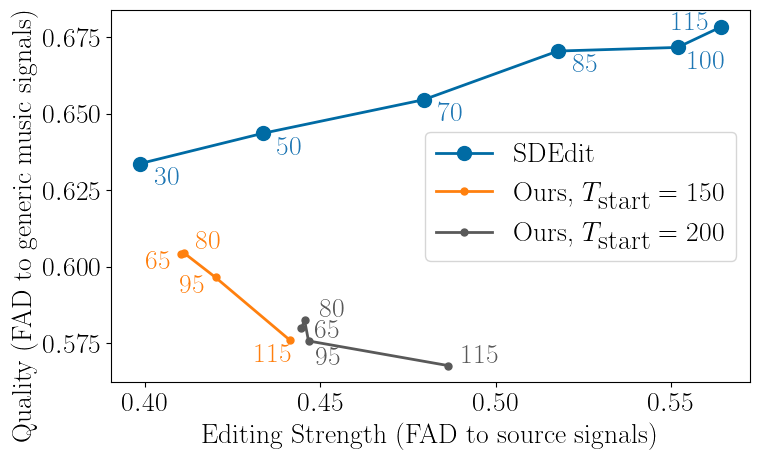

In [20]:
fig1 = plt.figure(figsize=(8,5))
shift_y = -0.007
shift_x = 0.004
ax = fig1.add_subplot(1, 1, 1)

sdedit_skips = sorted([170, 150, 130, 115, 100, 85])
    
sdedit_fad_fmapop = [[f for f in fad_fmapop if f['type'] == 'sdedit' and str(skip) in f['ptrn']][0]['sdedit_score_ninf'] for skip in sdedit_skips]    
sdedit_fad_orig = [[f for f in fad_orig if f['type'] == 'sdedit' and str(skip) in f['ptrn']][0]['sdedit_score_ninf'] for skip in sdedit_skips]    

sdedit_skips = 200 - np.array(sdedit_skips)

ax.plot(sdedit_fad_orig, sdedit_fad_fmapop, label='SDEdit', marker='o', markersize=10, linewidth=2)
for i, s in enumerate(sdedit_skips):
    if i == 0:
        ax.text(sdedit_fad_orig[i] - 0.014, sdedit_fad_fmapop[i] -0.0011, f'{s}', color='tab:blue')
    elif i == 1:
        ax.text(sdedit_fad_orig[i] + 0.003, sdedit_fad_fmapop[i] - 0.007, f'{s}', color='tab:blue')
    else:
        ax.text(sdedit_fad_orig[i] + shift_x, sdedit_fad_fmapop[i] + shift_y, f'{s}', color='tab:blue')

cur_spts = [65,80,95,115]
spts_200_fad_fmapop = []
spts_200_fad_orig = []
spts_150_fad_fmapop = []
spts_150_fad_orig = []
for jj, (spt, color) in enumerate(zip(cur_spts, ['lightcoral', 'indianred', 'firebrick', 'maroon', 'black'])):
    cur_drifts = [(200,-1), (150,-1)] 

    ours_fad_fmapop = [[f for f in fad_fmapop
                    if f['type'] == 'ours' and f'spts{spt}' in f['ptrn']
                    and f['ptrn'].startswith('**/pcs') == True
                    and (str(drift_start)+ '--1') in f['ptrn']
                ][0]['ours_score_ninf'] for drift_start in [200,150]]
    ours_fad_orig = [[f for f in fad_orig
                    if f['type'] == 'ours' and f'spts{spt}' in f['ptrn']
                    and f['ptrn'].startswith('**/pcs') == True
                    and (str(drift_start)+ '--1') in f['ptrn']
                    ][0]['ours_score_ninf'] for drift_start in [200,150]]
    
    spts_200_fad_fmapop.append(ours_fad_fmapop[0])
    spts_200_fad_orig.append(ours_fad_orig[0])
    spts_150_fad_fmapop.append(ours_fad_fmapop[1])
    spts_150_fad_orig.append(ours_fad_orig[1])
    
ax.plot(spts_150_fad_orig, spts_150_fad_fmapop, label='Ours, $T_\\textnormal{start}=150$', marker='.', linewidth=2, markersize=10)
for i, spt in enumerate(cur_spts):
    if i == 1:
        ax.text(spts_150_fad_orig[i] + 0.003, spts_150_fad_fmapop[i] + 0.0015, f'{spt}', color='tab:orange')
    elif i == len(cur_spts) - 1:
        ax.text(spts_150_fad_orig[i] - 0.01, spts_150_fad_fmapop[i] - 0.007, f'{spt}', color='tab:orange')
    else:
        ax.text(spts_150_fad_orig[i] - 0.01, spts_150_fad_fmapop[i] - 0.005, f'{spt}', color='tab:orange')

ax.plot(spts_200_fad_orig, spts_200_fad_fmapop, label='Ours, $T_\\textnormal{start}=200$', marker='.', color='#595959', markersize=10, linewidth=2)
for i, spt in enumerate(cur_spts):
    if i == 1:                
        ax.text(spts_200_fad_orig[i] + 0.004, spts_200_fad_fmapop[i] + 0.001, f'{spt}', color='#595959')
    elif i == 0:
        ax.text(spts_200_fad_orig[i] + 0.004, spts_200_fad_fmapop[i] - 0.003, f'{spt}', color='#595959')
    elif i == 2:
        ax.text(spts_200_fad_orig[i] + 0.002, spts_200_fad_fmapop[i] - 0.008, f'{spt}', color='#595959')
    else:
        ax.text(spts_200_fad_orig[i] + 0.004, spts_200_fad_fmapop[i] + 0.001, f'{spt}', color='#595959')

ax.set_xlabel('fad vs FMA score')
ax.set_xlabel('Editing Strength (FAD to source signals)')
h = ax.set_ylabel('Quality (FAD to generic music signals)')
x,y = h.get_position()
h.set_position([x, y-0.08])
ax.legend()

fig1.tight_layout()
# plt.savefig('figures/Unsup_FAD_FAD.pdf', pad_inches=0.015, bbox_inches='tight')
plt.show()

